In [14]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
from pathlib import Path
import logging
import argparse
import cv2
import matplotlib.pyplot as plt

In [15]:
# Setup logging
try:
    # Ensure log directory exists
    log_path = "logs/mscdae_v1_test.log"
    log_dir = os.path.dirname(os.path.abspath(log_path))
    os.makedirs(log_dir, exist_ok=True)
    
    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_path, mode='a'),  # 追加模式
            logging.StreamHandler()
        ]
    )
    # Force output of initial log to confirm logging system is working
    logging.info("Logging system initialized")
except Exception as e:
    print(f"Error setting up logging system: {str(e)}")

logger = logging.getLogger("MscdaeModule")
# Confirm logger is working properly
logger.info("Mscdae module initialized")

2025-05-20 11:28:49,246 - root - INFO - Logging system initialized
2025-05-20 11:28:49,249 - MscdaeModule - INFO - Mscdae module initialized


In [16]:
def load_and_preprocess_image(image_path, transform=None):
    """加载并预处理单张图像"""
    if transform is None:
        transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
    
    try:
        image = Image.open(image_path).convert('RGB')
        tensor = transform(image)
        return tensor, image
    except Exception as e:
        logger.error(f"Failed to load image '{image_path}' : {e}")
        return None, None

In [17]:
def visualize_results(results, save_path=None):
    """可视化检测结果"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 原始图像
    axes[0, 0].imshow(results['original'].permute(1, 2, 0).cpu().numpy())
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # 重建图像
    axes[0, 1].imshow(results['reconstructed'].permute(1, 2, 0).cpu().numpy())
    axes[0, 1].set_title('Reconstructing the image')
    axes[0, 1].axis('off')
    
    # 误差图
    error_map = results['error_map'].cpu().numpy()
    im = axes[1, 0].imshow(error_map, cmap='jet')
    axes[1, 0].set_title(f'Reconstruction error (mean: {error_map.mean():.4f})')
    axes[1, 0].axis('off')
    fig.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # 缺陷掩码
    axes[1, 1].imshow(results['defect_mask'].cpu().numpy(), cmap='gray')
    axes[1, 1].set_title(f'Defect Mask (Threshold: {results["threshold"]:.4f})')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Results saved to {save_path}")
    
    plt.show()

In [18]:
def apply_defect_mask(original_image, defect_mask, color=(0, 0, 255), alpha=0.5):
    """在原始图像上应用缺陷掩码，突出显示缺陷区域"""
    # 将原始图像转换为NumPy数组
    if isinstance(original_image, torch.Tensor):
        # 如果是张量，转换为NumPy数组并确保通道顺序正确(C,H,W -> H,W,C)
        original_np = original_image.permute(1, 2, 0).cpu().numpy()
    elif isinstance(original_image, Image.Image):
        # 如果是PIL图像，转换为NumPy数组
        original_np = np.array(original_image)
    else:
        original_np = original_image
    
    # 确保值范围在0-1之间
    if original_np.max() <= 1.0:
        original_np = (original_np * 255).astype(np.uint8)
    
    # 创建RGB图像(如果是灰度图)
    if len(original_np.shape) == 2 or original_np.shape[2] == 1:
        original_np = cv2.cvtColor(original_np, cv2.COLOR_GRAY2BGR)
    
    # 创建与原图相同大小的掩码图像
    mask_np = cv2.resize(defect_mask.cpu().numpy().astype(np.uint8) * 255, 
                         (original_np.shape[1], original_np.shape[0]))
    
    # 创建一个彩色覆盖图
    overlay = original_np.copy()
    overlay[mask_np > 0] = color
    
    # 将覆盖图与原图混合
    highlighted = cv2.addWeighted(overlay, alpha, original_np, 1 - alpha, 0)
    
    return highlighted

In [19]:
def detect_defects(model, image, device, threshold_factor=2.0):
    """检测图像中的缺陷"""
    # 确保模型在评估模式
    model.eval()
    
    # 将图像移至设备
    image = image.to(device)
    
    with torch.no_grad():
        # 获取重建图像
        reconstructed = model(image.unsqueeze(0)).squeeze(0)
        
        # 计算重建误差
        error_map = torch.abs(image - reconstructed)
        
        # 计算每个通道的误差统计
        if error_map.dim() > 2:  # 多通道图像
            # 转换为灰度误差图
            error_map = torch.mean(error_map, dim=0)
        
        # 设置自适应阈值
        threshold = error_map.mean() + threshold_factor * error_map.std()
        defect_mask = error_map > threshold
        
        # 返回结果
        return {
            'original': image.cpu(),
            'reconstructed': reconstructed.cpu(),
            'error_map': error_map.cpu(),
            'defect_mask': defect_mask.cpu(),
            'threshold': threshold.item()
        }

In [20]:
def test_single_image(model, image_path, device, threshold_factor=2.0, save_dir=None):
    """测试单张图像并可视化结果"""
    # 加载并预处理图像
    image_tensor, original_image = load_and_preprocess_image(image_path)
    if image_tensor is None:
        return
    
    # 检测缺陷
    results = detect_defects(model, image_tensor, device, threshold_factor)
    
    # 可视化结果
    if save_dir:
        save_path = os.path.join(save_dir, f"{Path(image_path).stem}_results.png")
    else:
        save_path = None
    
    visualize_results(results, save_path)
    
    # 在原始图像上标记缺陷
    highlighted_image = apply_defect_mask(original_image, results['defect_mask'])
    
    if save_dir:
        highlight_path = os.path.join(save_dir, f"{Path(image_path).stem}_highlighted.png")
        cv2.imwrite(highlight_path, cv2.cvtColor(highlighted_image, cv2.COLOR_RGB2BGR))
        logger.info(f"Marked image saved to {highlight_path}")
    
    plt.figure(figsize=(8, 8))
    plt.imshow(highlighted_image)
    plt.title("Marked defects")
    plt.axis('off')
    plt.show()
    
    return results

In [21]:
def test_batch_images(model, image_dir, device, threshold_factor=2.0, save_dir=None):
    """测试文件夹中的所有图像"""
    # 确保保存目录存在
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # 获取所有图像文件
    image_files = [f for f in os.listdir(image_dir) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    if not image_files:
        logger.error(f"No image file found in directory '{image_dir}'")
        return
    
    logger.info(f"{len(image_files)} image files found")
    
    # 对每个图像进行测试
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        logger.info(f"Process image: {image_path}")
        try:
            test_single_image(model, image_path, device, threshold_factor, save_dir)
        except Exception as e:
            logger.error(f"Error processing image '{image_path}': {e}")
            import traceback
            traceback.print_exc()

In [22]:
# 选择设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Device used: {device}")

2025-05-20 11:28:49,406 - MscdaeModule - INFO - Device used: cpu


In [23]:
import mscdae_v1

In [24]:
model_path = "mscdae_v1_models/best_mscdae_v1_model.pth"
model = mscdae_v1.MSCDAE().to(device)
data_dir = "data/test_raw"
threshold = 2
output_dir = "data/mscdae_v1_test_raw_results"

In [25]:
# 加载模型权重
if not os.path.exists(model_path):
    logger.error(f"Model file '{model_path}' does not exist")
else:
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    logger.info(f"Loaded model '{model_path}'")

2025-05-20 11:28:49,618 - MscdaeModule - INFO - Loaded model 'mscdae_v1_models/best_mscdae_v1_model.pth'


2025-05-20 11:28:49,652 - MscdaeModule - INFO - Test all images in directory: data/test_raw
2025-05-20 11:28:49,655 - MscdaeModule - INFO - 5 image files found
2025-05-20 11:28:49,656 - MscdaeModule - INFO - Process image: data/test_raw\aa.png
2025-05-20 11:28:51,021 - MscdaeModule - INFO - Results saved to data/mscdae_v1_test_raw_results\aa_results.png


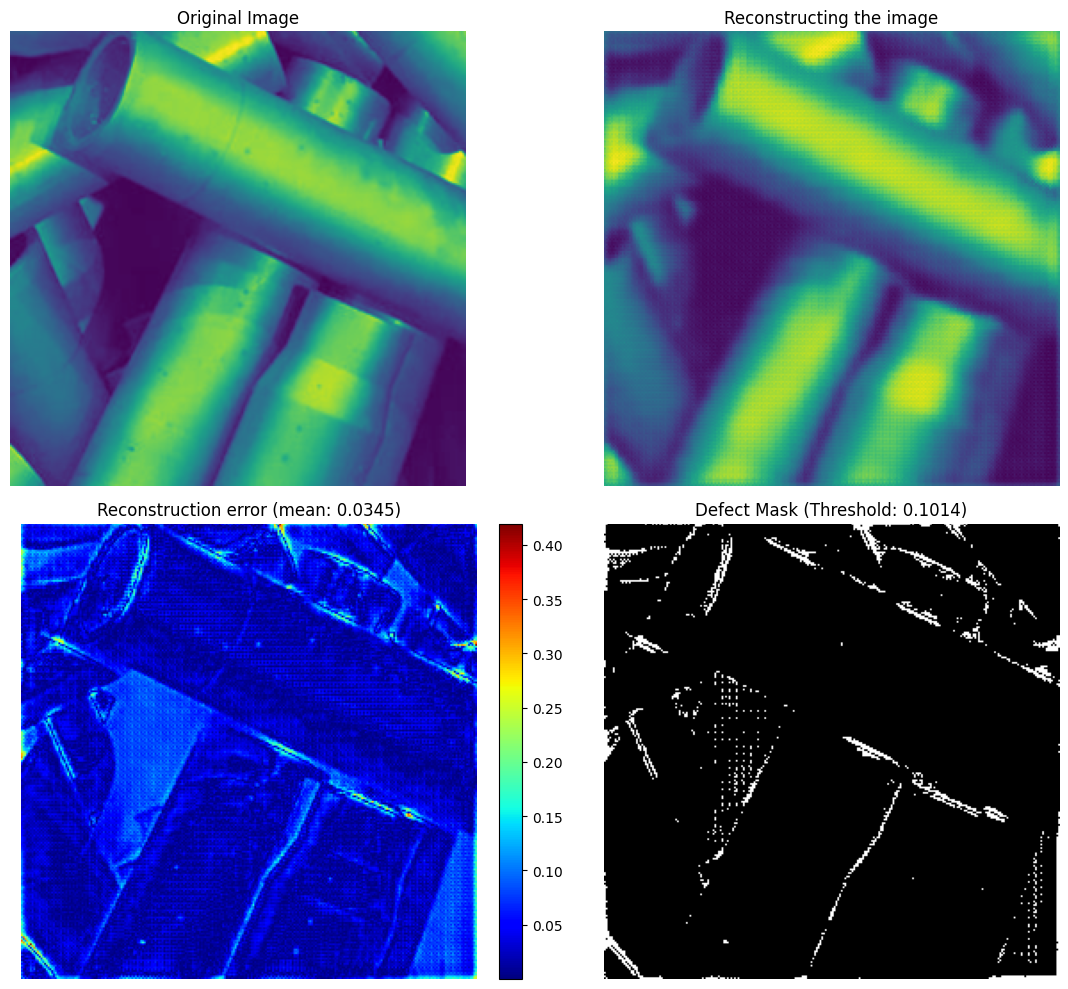

2025-05-20 11:28:51,550 - MscdaeModule - INFO - Marked image saved to data/mscdae_v1_test_raw_results\aa_highlighted.png


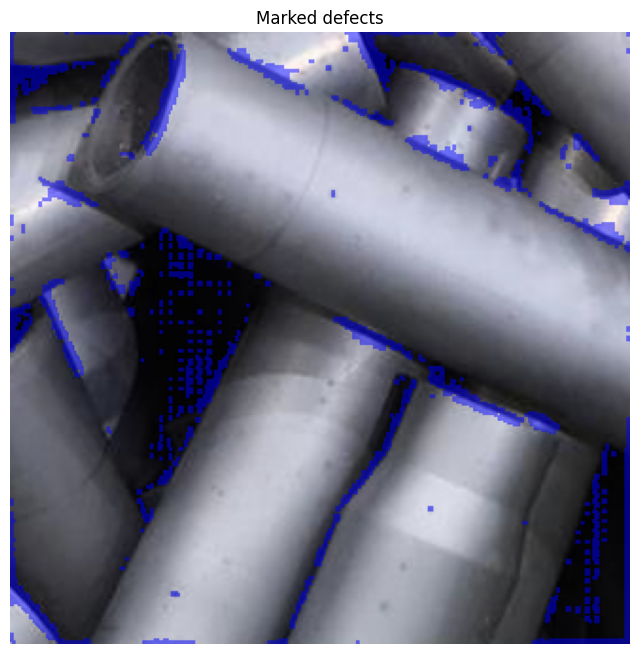

2025-05-20 11:28:51,682 - MscdaeModule - INFO - Process image: data/test_raw\nc1.png
2025-05-20 11:28:52,946 - MscdaeModule - INFO - Results saved to data/mscdae_v1_test_raw_results\nc1_results.png


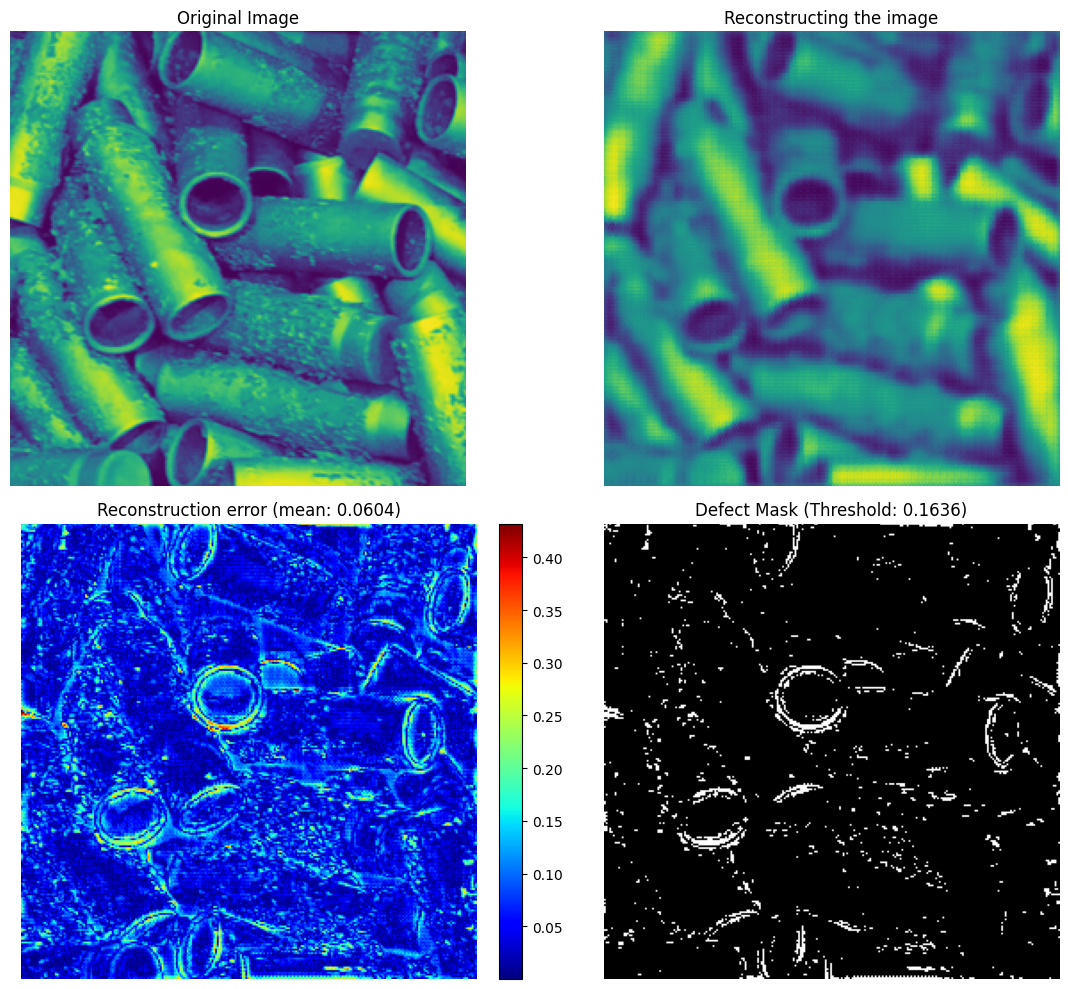

2025-05-20 11:28:53,656 - MscdaeModule - INFO - Marked image saved to data/mscdae_v1_test_raw_results\nc1_highlighted.png


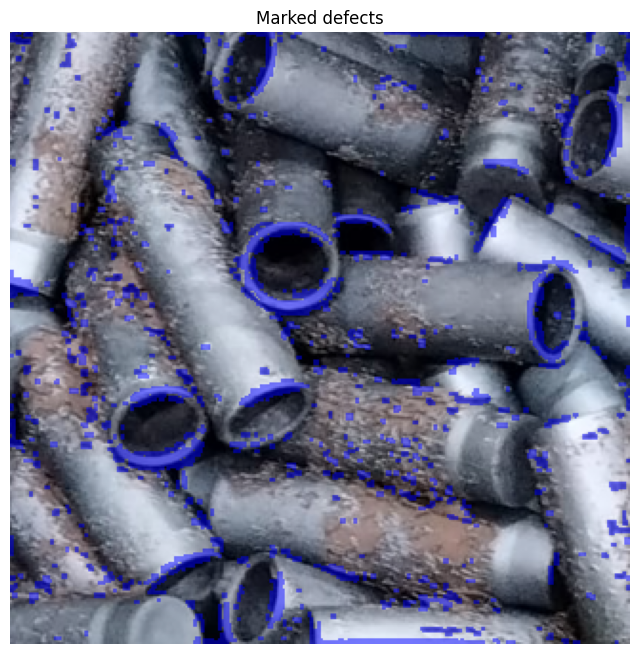

2025-05-20 11:28:53,948 - MscdaeModule - INFO - Process image: data/test_raw\nc2.png
2025-05-20 11:28:55,538 - MscdaeModule - INFO - Results saved to data/mscdae_v1_test_raw_results\nc2_results.png


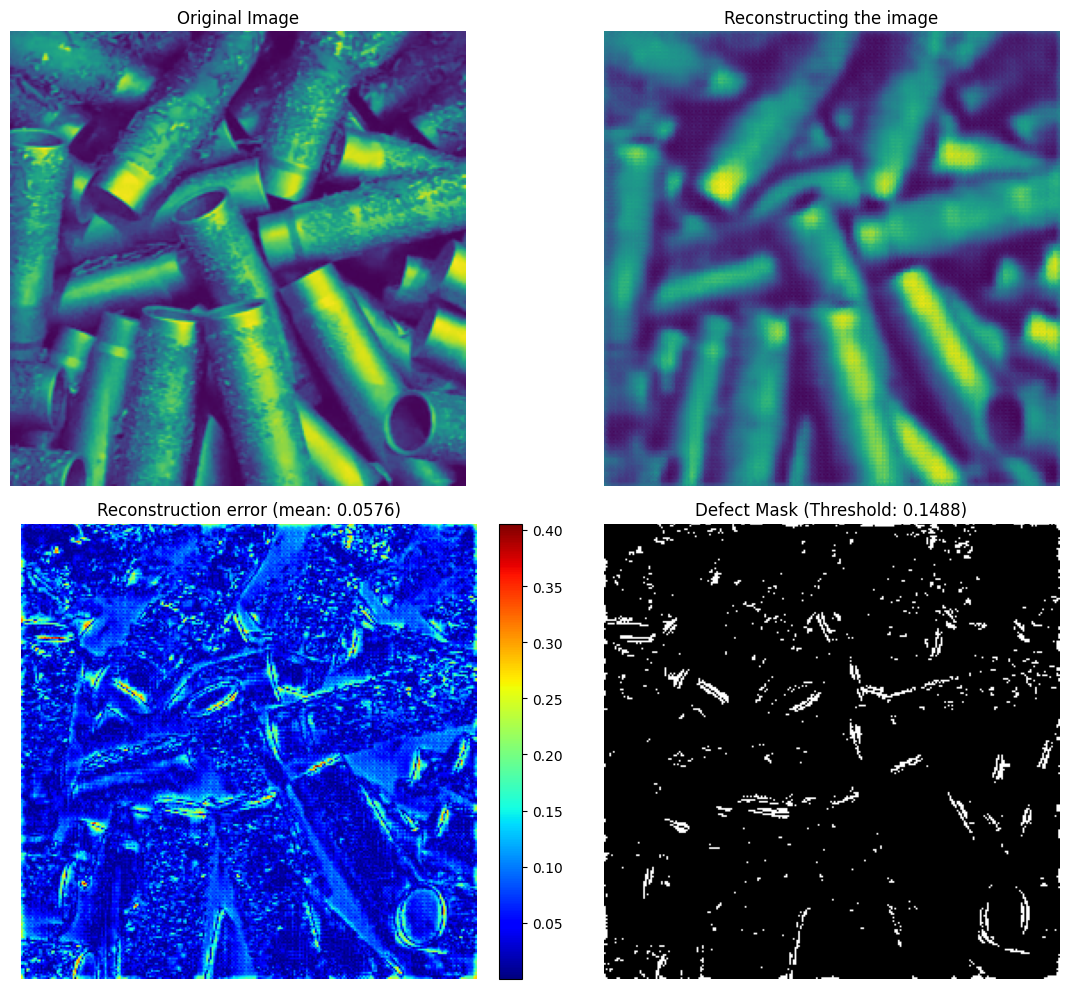

2025-05-20 11:28:56,326 - MscdaeModule - INFO - Marked image saved to data/mscdae_v1_test_raw_results\nc2_highlighted.png


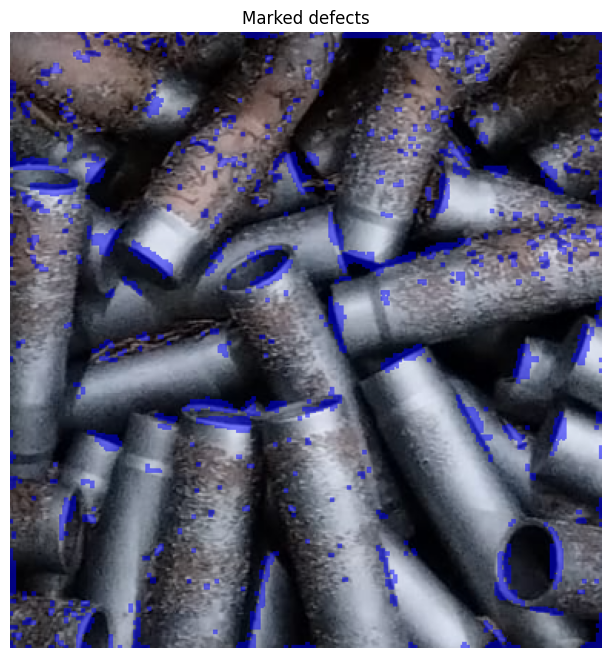

2025-05-20 11:28:56,560 - MscdaeModule - INFO - Process image: data/test_raw\nc3.png
2025-05-20 11:28:57,813 - MscdaeModule - INFO - Results saved to data/mscdae_v1_test_raw_results\nc3_results.png


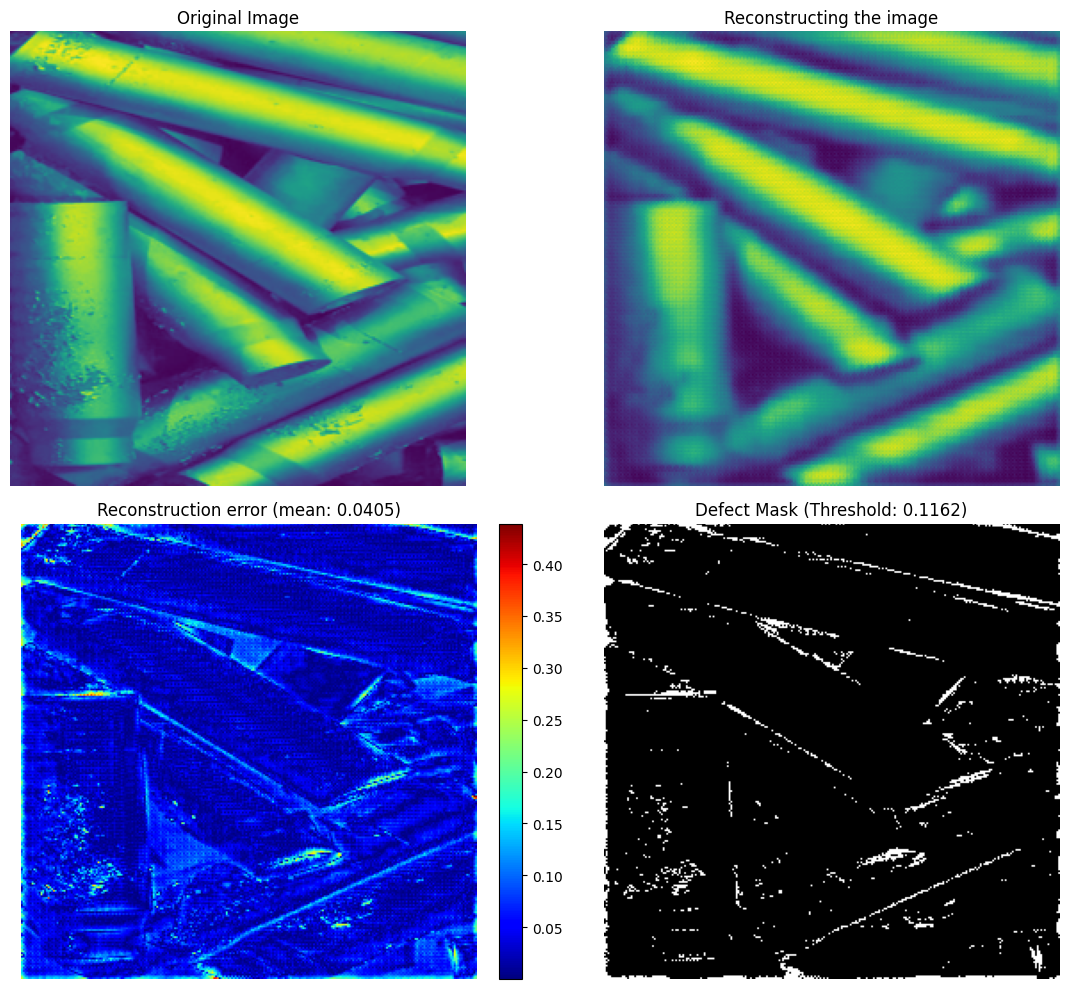

2025-05-20 11:28:58,745 - MscdaeModule - INFO - Marked image saved to data/mscdae_v1_test_raw_results\nc3_highlighted.png


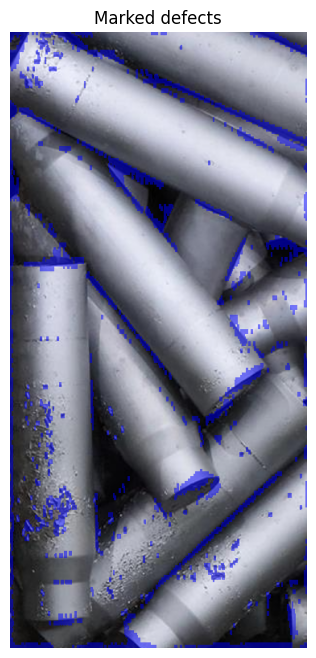

2025-05-20 11:28:58,958 - MscdaeModule - INFO - Process image: data/test_raw\nc4.png
2025-05-20 11:29:01,131 - MscdaeModule - INFO - Results saved to data/mscdae_v1_test_raw_results\nc4_results.png


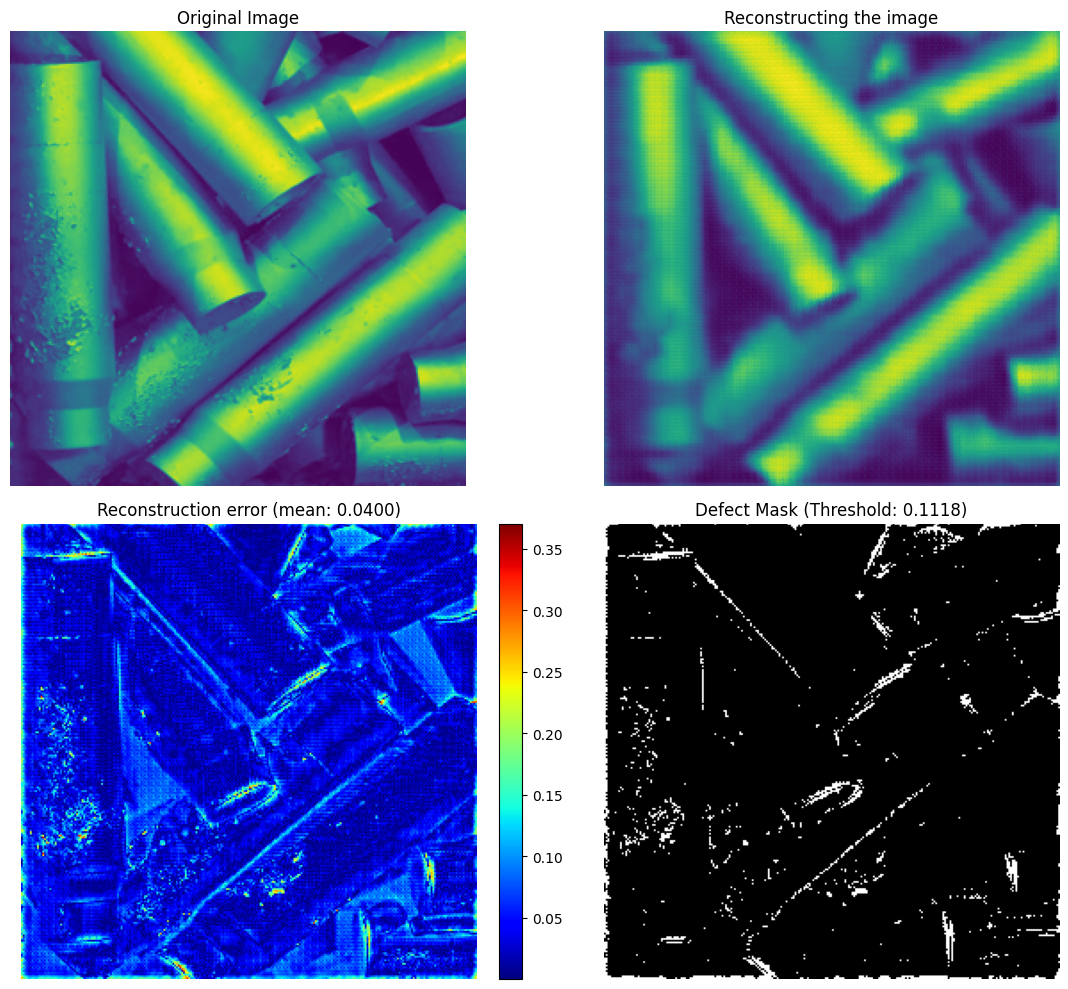

2025-05-20 11:29:02,561 - MscdaeModule - INFO - Marked image saved to data/mscdae_v1_test_raw_results\nc4_highlighted.png


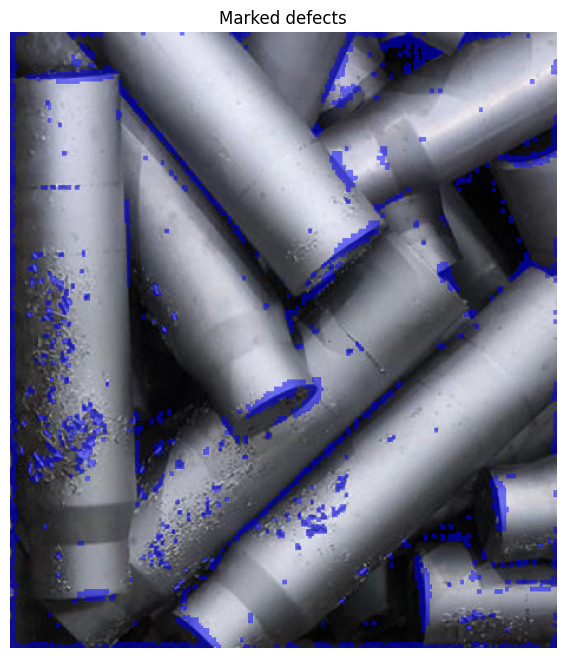

In [26]:
if os.path.exists(data_dir):
    logger.info(f"Test all images in directory: {data_dir}")
    test_batch_images(model, data_dir, device, threshold, output_dir)
else:
    logger.error(f"Data directory '{data_dir}' does not exist")